Best DBSCAN params: {'eps': 1.5, 'min_samples': 20}, silhouette=0.397
where Silhouette score measures how well each point lies within its cluster, versus the next nearest cluster.

Confusion Matrix:
[[94950  2328]
 [    4  3373]]

Classification Report:
              precision    recall  f1-score   support

      normal       1.00      0.98      0.99     97278
      attack       0.59      1.00      0.74      3377

    accuracy                           0.98    100655
   macro avg       0.80      0.99      0.87    100655
weighted avg       0.99      0.98      0.98    100655



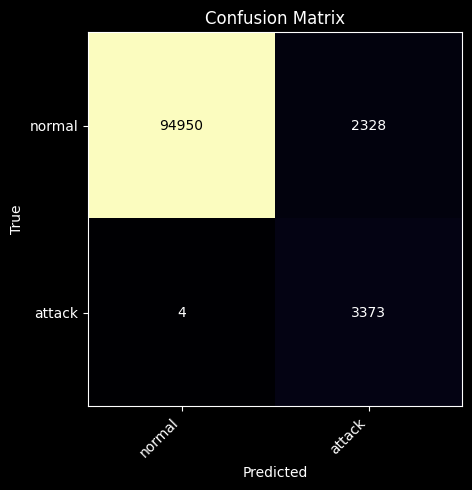

In [9]:
# network intrusion detection using DBSCAN clustering
# using this dataset -- https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.datasets import fetch_kddcup99
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, classification_report, silhouette_score

# data preprocessing -- Fetch raw KDD Cup ’99 data
data = fetch_kddcup99(subset='SA', percent10=True, shuffle=True, random_state=42)
X_raw = pd.DataFrame(data.data, columns=data.feature_names)
y_raw = pd.Series(data.target).str.decode('utf-8')

# map labels to binary: 'normal' vs. 'attack'
y = (y_raw != 'normal.').astype(int)  # 0 = normal, 1 = attack

# identify categorical vs. numeric features
cat_cols = ['protocol_type', 'service', 'flag']
num_cols = [c for c in X_raw.columns if c not in cat_cols]

# One-hot encoding categorical features in a dataset using Scikit-learn's OneHotEncoder.  This converts
# categorical data into a numerical format.  It creates binary columns for each category in a feature, 
# where a value of `1` indicates the presence of a category, and `0` indicates its absence.
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = ohe.fit_transform(X_raw[cat_cols])

# Using Scikit-learn's `StandardScaler' -- this will standardize the numeric features so that they 
# have a mean of 0 and a standard deviation of 1.
scaler = StandardScaler()
X_num = scaler.fit_transform(X_raw[num_cols])

# Combine the numerical and categorical features back into a single feature matrix
X = np.hstack([X_num, X_cat])

# (note to self: create autoencoder to reduce dimensionality of X)

# Training and hyperparameter tuning for DBSCAN clustering

best_params = {}
best_score = -1

# Simple grid search over eps and min_samples to optimize the hyperparameters of the DBSCAN clustering algorithm
# eps: maximum distance between two samples for one to be considered as in the neighborhood of the other
# min_samples: number of points that must lie within an eps–radius neighborhood for a point to be classified as a core point.
for eps in [0.5, 1.0, 1.5]:
    for min_samples in [5, 10, 20]: # try different values for min_samples
        db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1) # n_jobs=-1 uses all processors
        labels = db.fit_predict(X) # fit_predict returns cluster labels for each point in the dataset     
        mask = labels != -1 # Ignore “noise” label (-1) in silhouette score
        if len(set(labels[mask])) > 1: # check if there are at least 2 clusters (excluding noise)
            score = silhouette_score(X[mask], labels[mask]) # calculate silhouette score
            if score > best_score: # update best score and params
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best DBSCAN params: {best_params}, silhouette={best_score:.3f}")
print('where Silhouette score measures how well each point lies within its cluster, versus the next nearest cluster.')

# Train final model
db_final = DBSCAN(**best_params, n_jobs=-1)
cluster_labels = db_final.fit_predict(X)

# Map clusters to “normal” vs. “attack”
# We will treat “noise” (‑1) as attack, and any cluster >0: assign cluster → majority true label
# Map the clusters generated by the DBSCAN algorithm to binary labels representing "normal" (0) and "attack" (1).
pred = np.zeros_like(cluster_labels)
pred[cluster_labels == -1] = 1 # first, mark all noise as attack

for cl in np.unique(cluster_labels): # for each cluster, assign based on majority y
    if cl == -1: continue
    mask = cluster_labels == cl
    pred[mask] = int(np.round(y[mask].mean()))  # 0 normal or 1 attack

# Confusion Matrix & Classification Report
cm = confusion_matrix(y, pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y, pred, target_names=['normal','attack']))

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, interpolation='nearest', cmap='magma')
ax.set_title("Confusion Matrix")
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['normal','attack'])
ax.set_yticklabels(['normal','attack'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Adjust text color based on background intensity
for i in range(2):
    for j in range(2):
        text_color = "black" if im.norm(cm[i, j]) > 0.5 else "white"
        ax.text(j, i, cm[i, j],
                ha="center", va="center", color=text_color)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()